#**Import datasets API from Kaggel :**

* **CDC Diabetes Health Indicators (Tabular, Classification)**

* **NYC Taxi Fare Prediction (Tabular, Regression)**

* **Chest X-Ray Images (Image, Classification)**

# Import libraries , install kaggle and upload your JSON file

In [ ]:
# 1. Install packages not included in standard Colab
!pip install -q kaggle lime shap scikit-image

# 2. Standard Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# 3. Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split , cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score ,classification_report , confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE


# 4. Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor

# 5. Explainable AI (XAI) & Inspection
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import lime
from lime import lime_tabular, lime_image, lime_text
from sklearn.utils import resample # Needed for ICE sampling

# 6. Text & Image Specific
from sklearn.feature_extraction.text import TfidfVectorizer
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# 7. Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

from glob import glob
from tqdm import tqdm
from scipy.sparse import hstack

print("Libraries loaded successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Libraries loaded successfully!


In [ ]:
# 1. Install the Kaggle library
!pip install -q kaggle

# 2. Upload your kaggle.json file
# ACTION REQUIRED: Run this cell, click "Choose Files", and select your kaggle.json file.
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# 3. Move the file to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API setup complete!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API setup complete!


# Dataset 1: CDC Diabetes Health Indicators

* (Tabular, Classification)
* Link: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

Solution (XAI Application):


*   Permutation Feature Importance
*   PDP
*   ICE
*   LIME



In [ ]:
# --- Dataset 1: CDC Diabetes Health Indicators ---
print("\n--- Downloading Dataset 1: Diabetes Health Indicators ---")
!mkdir -p dataset_1
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset -p dataset_1
!unzip -q dataset_1/diabetes-health-indicators-dataset.zip -d dataset_1
!rm dataset_1/diabetes-health-indicators-dataset.zip
print("Dataset 1 ready in folder: dataset_1/")


--- Downloading Dataset 1: Diabetes Health Indicators ---
Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 362MB/s]
Dataset 1 ready in folder: dataset_1/


##Analyzing

In [ ]:
try:
    df = pd.read_csv('/content/dataset_1/diabetes_binary_health_indicators_BRFSS2015.csv')
    print("Dataset loaded successfully.\n")
except FileNotFoundError:
    print("ERROR: File not found. Make sure 'data_diabetes/diabetes_binary_health_indicators_BRFSS2015.csv' exists.")
    # Create a dummy df to prevent crashes, though the rest of the analysis will be meaningless
    df = pd.DataFrame()

Dataset loaded successfully.



In [ ]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
df.shape

(253680, 22)

In [ ]:
print("\nUpdated Column Info:")
df.info()


Updated Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 n

In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
253675,False
253676,False
253677,False
253678,False


In [ ]:
df.duplicated().sum()

np.int64(24206)

In [ ]:
df.isnull().sum()

,0
Diabetes_binary,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
HeartDiseaseorAttack,0
PhysActivity,0
Fruits,0


In [ ]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [ ]:
target_counts = df['Diabetes_binary'].value_counts()
target_percent = df['Diabetes_binary'].value_counts(normalize=True) * 100
print("Target Variable Counts:")
print(target_counts)
print("\nTarget Variable Percentage:")
print(target_percent)

Target Variable Counts:
Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

Target Variable Percentage:
Diabetes_binary
0.0    86.066698
1.0    13.933302
Name: proportion, dtype: float64


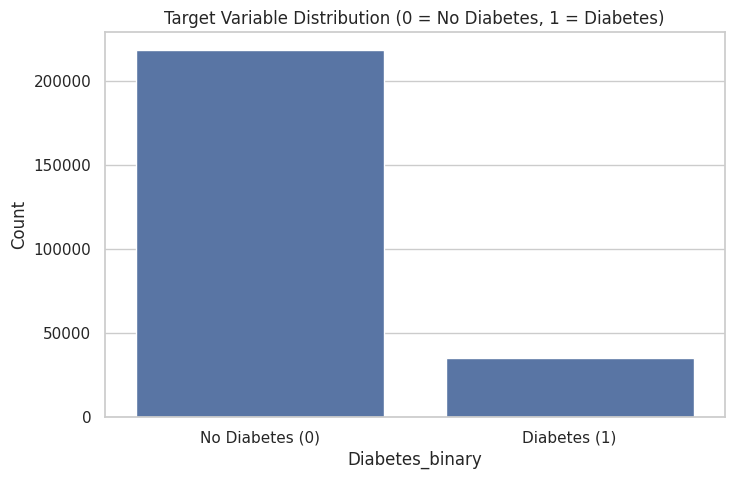

In [ ]:
# Plot the target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Diabetes_binary', data=df)
plt.title('Target Variable Distribution (0 = No Diabetes, 1 = Diabetes)')
plt.xlabel('Diabetes_binary')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.show()

##pre-processing

In [ ]:
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

In [ ]:
num_cols_diab = ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
cat_cols_diab = [c for c in X.columns if c not in num_cols_diab]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
preprocessor_diab = ColumnTransformer([
    ('num', StandardScaler(), num_cols_diab),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_diab)
])

In [ ]:
print(f"Original training shape: {X_train.shape}")
print(f"Original testing shape: {X_test.shape}")

Original training shape: (202944, 21)
Original testing shape: (50736, 21)


In [ ]:
# 5. Fit and Transform Data
X_train_scaled = preprocessor_diab.fit_transform(X_train)
X_test_scaled = preprocessor_diab.transform(X_test)

In [ ]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Update your main variables to use the balanced training data
X_train_final = X_train_balanced
y_train_final = y_train_balanced
X_test_final = X_test_scaled # Test data remains unbalanced but scaled

print("Diabetes feature engineering & balancing complete.")
print(f"Original Train shape: {X_train_scaled.shape}, Balanced Train shape: {X_train_final.shape}")

Diabetes feature engineering & balancing complete.
Original Train shape: (202944, 39), Balanced Train shape: (349334, 39)


##Build the models and evaluation

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'MLP (Neural Network)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, early_stopping=True),
}

In [ ]:
# Train all models
for name, model in models.items():
    print(f"Training {name}...")
    # Train on the SCALED and BALANCED training data
    model.fit(X_train_final, y_train_final)
    pre = model.predict(X_test_final)
    accuracy = model.score(X_test_final, y_test)
    print(f"{name} accuracy: {accuracy:.4f}")
    print(classification_report(y_test, pre))
    print("=====================================")
    print()
print("\nAll models trained successfully.")

Training Random Forest...
Random Forest accuracy: 0.8447
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     43667
         1.0       0.42      0.29      0.34      7069

    accuracy                           0.84     50736
   macro avg       0.65      0.61      0.63     50736
weighted avg       0.82      0.84      0.83     50736


Training Gradient Boosting...
Gradient Boosting accuracy: 0.8325
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     43667
         1.0       0.41      0.48      0.45      7069

    accuracy                           0.83     50736
   macro avg       0.66      0.69      0.67     50736
weighted avg       0.84      0.83      0.84     50736


Training MLP (Neural Network)...
MLP (Neural Network) accuracy: 0.7556
              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84     43667
         1.0       0.32      0.66      0.4

--- Model Evaluation on Test Set ---


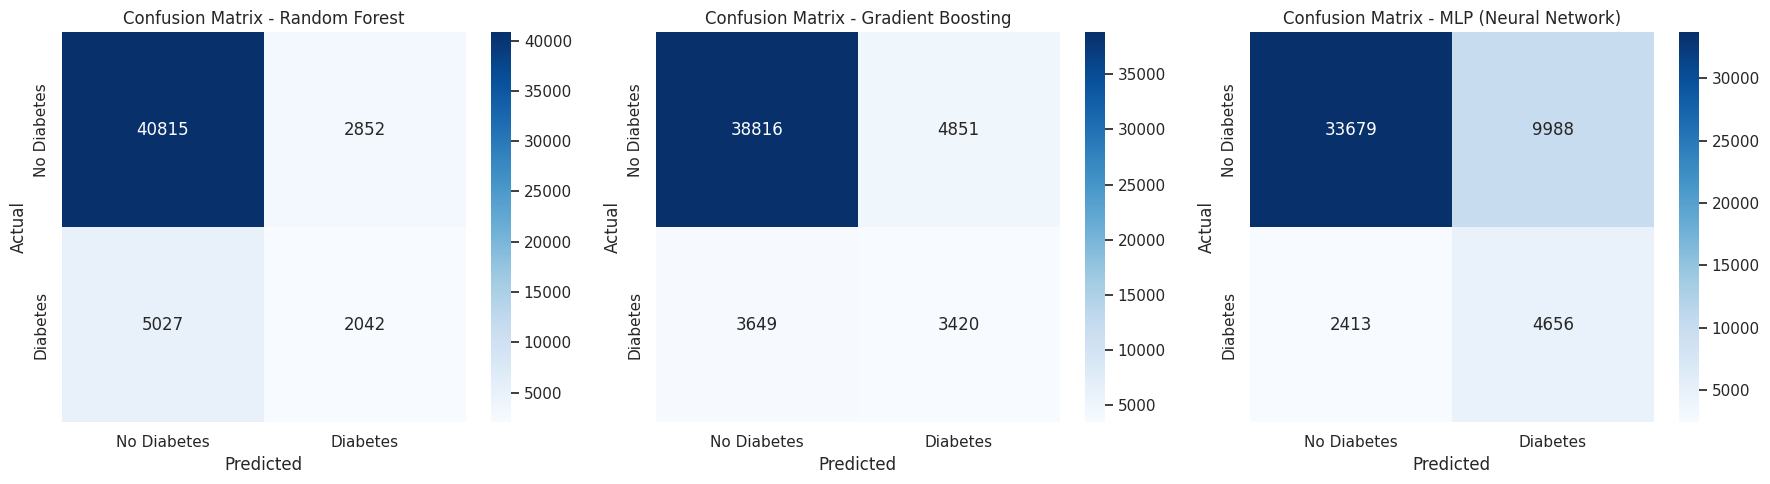

In [ ]:
print("--- Model Evaluation on Test Set ---")

# Get the number of models to create appropriate subplot grid
num_models = len(models)

# Create a single figure with multiple subplots arranged horizontally
# Adjust figsize as needed based on the number of models
fig, axes = plt.subplots(1, num_models, figsize=(num_models * 6, 5))

# Ensure axes is always an array, even if there's only one model
if num_models == 1:
    axes = [axes]

for i, (name, model) in enumerate(models.items()):
    # Make predictions on the scaled test data
    y_pred = model.predict(X_test_scaled)

    # Display a confusion matrix on the corresponding subplot
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'],
                ax=axes[i]) # Plot on the i-th subplot
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

## Apply XAI

###XAI Analysis Starting

In [ ]:
print("--- XAI Analysis Starting ---")

# --- 0. Get Feature Names (CRITICAL STEP) ---
# We need the feature names from the preprocessor to label our plots
try:
    # Get the feature names from the fitted preprocessor
    feature_names = preprocessor_diab.get_feature_names_out()
    print(f"Successfully loaded {len(feature_names)} feature names.")
except Exception as e:
    print(f"Error getting feature names: {e}")
    print("Please ensure 'preprocessor_diab' is a fitted ColumnTransformer.")
    feature_names = [f'feature_{i}' for i in range(X_test_final.shape[1])]

--- XAI Analysis Starting ---
Successfully loaded 39 feature names.


###Permutation Feature Importance


--- 1. Calculating Permutation Feature Importance... ---


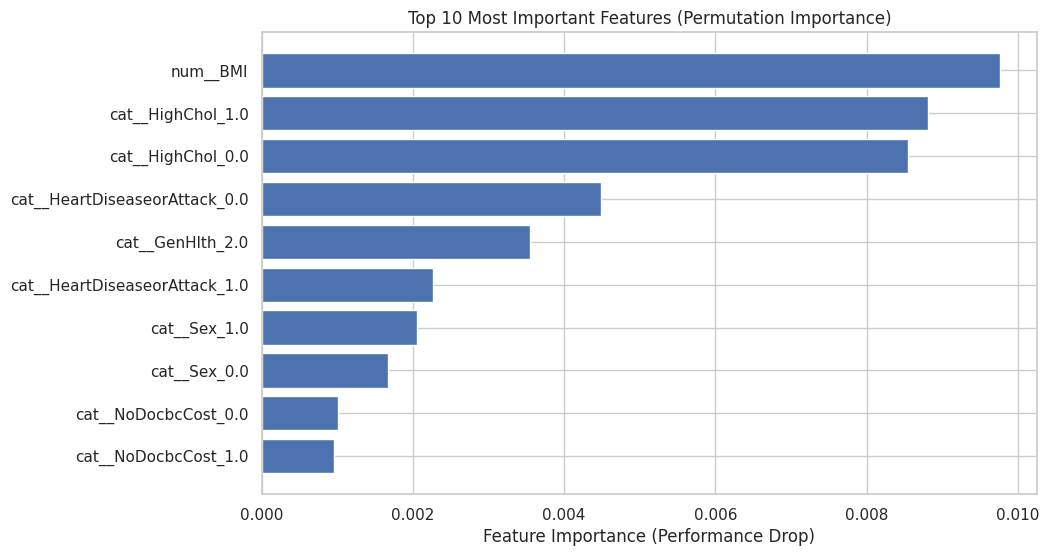

In [ ]:
model_to_explain = models['Gradient Boosting']

print("\n--- 1. Calculating Permutation Feature Importance... ---")
# This can take a minute as it re-runs predictions
result = permutation_importance(
    model_to_explain,
    X_test_final,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Get the top 10 most important features
sorted_idx = result.importances_mean.argsort()
top_10_idx = sorted_idx[-10:]
top_10_names = [feature_names[i] for i in top_10_idx]
top_10_importances = result.importances_mean[top_10_idx]

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(top_10_names, top_10_importances)
plt.xlabel("Feature Importance (Performance Drop)")
plt.title("Top 10 Most Important Features (Permutation Importance)")
plt.show()

###PDP


--- 2. Calculating Partial Dependence Plots (PDP)... ---


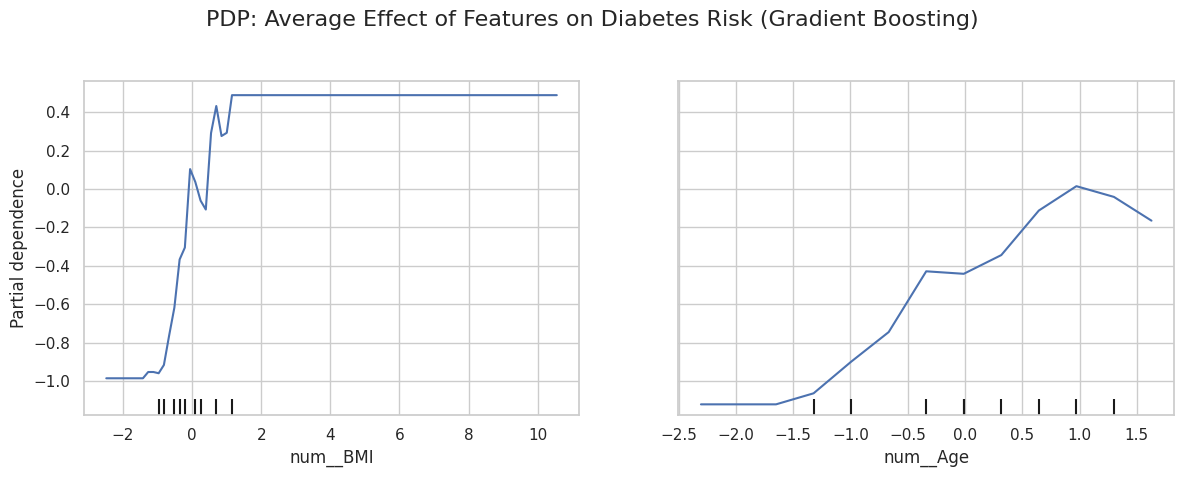

In [ ]:
print("\n--- 2. Calculating Partial Dependence Plots (PDP)... ---")

# Find the indices for the features we want to plot
# 'num__BMI' and 'num__Age' are the names from the ColumnTransformer
# Based on your notebook, 'GenHlth' was treated as categorical, so we'll plot
# the numerical features 'BMI' and 'Age'
try:
    features_to_plot_names = ['num__BMI', 'num__Age']
    features_to_plot_indices = [list(feature_names).index(f) for f in features_to_plot_names]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.suptitle('PDP: Average Effect of Features on Diabetes Risk (Gradient Boosting)', fontsize=16)
    PartialDependenceDisplay.from_estimator(
        model_to_explain,
        X_test_final,            # Use the preprocessed test data
        features=features_to_plot_indices,  # Use the indices
        feature_names=feature_names,        # Pass all names
        kind="average", # "average" tells it to plot PDP
        n_cols=2,
        ax=ax,
        n_jobs=-1 # Use all cores
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except ValueError as e:
    print(f"Could not find feature for PDP: {e}. Check your 'num_cols_diab' list in the preprocessing step.")

###ICE


--- 3. Calculating Individual Conditional Expectation (ICE)... ---


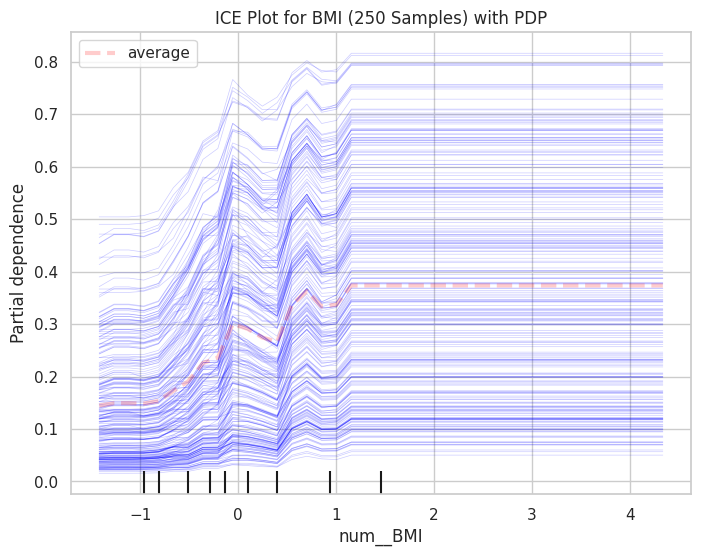

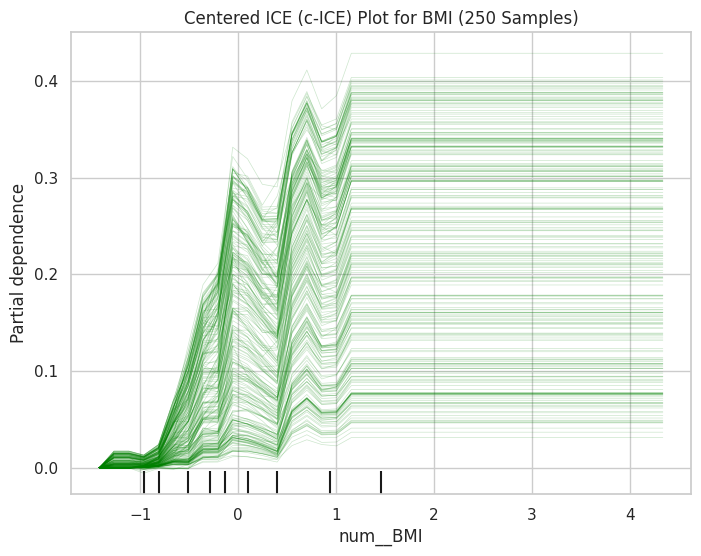

In [ ]:
print("\n--- 3. Calculating Individual Conditional Expectation (ICE)... ---")

# ICE plots are messy with too many lines. Let's sample 250 patients.
# We stratify by y_test to get a representative mix of diabetic/non-diabetic.
X_test_sample, y_test_sample = resample(
    X_test_final,
    y_test,
    n_samples=250,
    random_state=42,
    stratify=y_test
)

# Plot for BMI
try:
    bmi_index = list(feature_names).index('num__BMI')

    # 1. Standard ICE Plot (plotted on top of the PDP)
    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        model_to_explain,
        X_test_sample,
        features=[bmi_index],
        feature_names=feature_names,
        kind="both", # "both" plots ICE lines and the average PDP line
        ax=ax,
        n_jobs=-1,
        line_kw={"color": "blue", "alpha": 0.2}, # ICE lines
        pd_line_kw={"color": "red", "linestyle": "--", "linewidth": 3} # PDP line
    )
    ax.set_title('ICE Plot for BMI (250 Samples) with PDP')

    # 2. Centered ICE (c-ICE) Plot - Often easier to read
    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        model_to_explain,
        X_test_sample,
        features=[bmi_index],
        feature_names=feature_names,
        kind="individual",
        centered=True, # This centers all lines at the start
        ax=ax,
        n_jobs=-1,
        line_kw={"color": "green", "alpha": 0.2}
    )
    ax.set_title('Centered ICE (c-ICE) Plot for BMI (250 Samples)')
    plt.show()

except ValueError as e:
    print(f"Could not find 'num__BMI': {e}. Check your 'num_cols_diab' list.")

###LIME

In [ ]:
# --- 1. Create the LIME Explainer ---
# We initialize the explainer with our balanced training data.
# This helps LIME understand the statistics (mean, std) of your data.
try:
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train_final,
        feature_names=list(feature_names),
        class_names=['No Diabetes', 'Diabetes'],
        mode='classification',
        random_state=42
    )
    print("LIME Explainer created successfully.")
except Exception as e:
    print(f"Error creating LIME explainer: {e}")
    print("Ensure 'X_train_final' is a numpy array (which it should be from SMOTE).")

LIME Explainer created successfully.



Explaining Patient #1...
  - Model's Prediction: 'Diabetes'
  - Actual Label: 'Diabetes'

LIME Explanation Generated:
Explanation saved to 'lime_explanation_diabetes.html'.


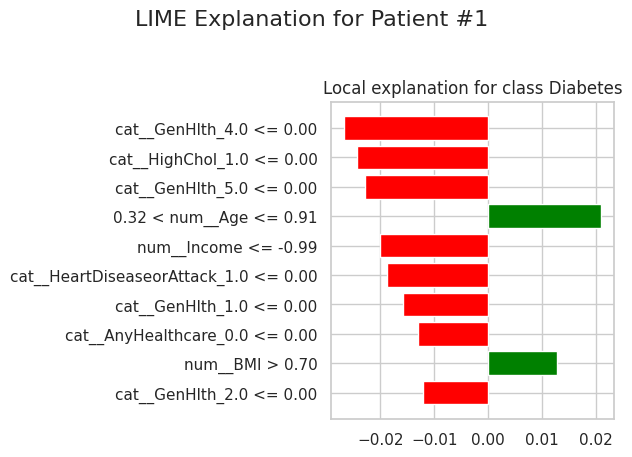


--- LIME Analysis Complete ---


In [ ]:
# --- 2. Select a Patient to Explain ---
# Let's find an interesting case: a "True Positive" where the model
# correctly predicted a patient has diabetes.
y_pred_gb = model_to_explain.predict(X_test_final)
true_positives = np.where((y_test == 1) & (y_pred_gb == 1))[0]

if len(true_positives) > 0:
    patient_idx = true_positives[0] # Get the first one
    patient_data = X_test_final[patient_idx]

    print(f"\nExplaining Patient #{patient_idx}...")
    print(f"  - Model's Prediction: 'Diabetes'")
    print(f"  - Actual Label: 'Diabetes'")

    # --- 3. Generate the Explanation ---
    # We ask LIME to explain the model's prediction for this single patient
    # We must use 'predict_proba' for LIME classification
    exp = explainer.explain_instance(
        data_row=patient_data,
        predict_fn=model_to_explain.predict_proba,
        num_features=10 # Show the top 10 most important features for this case
    )

    # --- 4. Show the Explanation ---
    print("\nLIME Explanation Generated:")

    # This command saves the plot as an HTML file you can open
    exp.save_to_file('lime_explanation_diabetes.html')
    print("Explanation saved to 'lime_explanation_diabetes.html'.")

    # This plots the explanation as a bar chart
    fig = exp.as_pyplot_figure()
    fig.suptitle(f"LIME Explanation for Patient #{patient_idx}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("Could not find a True Positive patient to explain in the test set.")
    print("Try explaining a True Negative (where y_test == 0) instead.")

print("\n--- LIME Analysis Complete ---")

# Dataset 2: NYC Taxi Fare Prediction
* (Tabular, Regression)
* Link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data


In [ ]:
# # --- Dataset 2: NYC Taxi Fare Prediction ---
print("\n--- Downloading Dataset 2: NYC Taxi Fare Prediction ---")
!mkdir -p dataset_2
!kaggle competitions download -c new-york-city-taxi-fare-prediction -p dataset_2
!unzip -q dataset_2/new-york-city-taxi-fare-prediction.zip -d dataset_2
!rm dataset_2/new-york-city-taxi-fare-prediction.zip
print("Dataset 2 ready in folder: dataset_2/")


--- Downloading Dataset 2: NYC Taxi Fare Prediction ---
100% 1.55G/1.56G [00:15<00:00, 284MB/s]
100% 1.56G/1.56G [00:15<00:00, 105MB/s]
Dataset 2 ready in folder: dataset_2/


## Analysing



In [ ]:
NROWS = 1000000
try:
    df_taxi = pd.read_csv('/content/dataset_2/train.csv', nrows=NROWS)
    print(f"Dataset loaded successfully (sampled {NROWS} rows).\n")
except FileNotFoundError:
    print("ERROR: File not found. Make sure 'dataset_2/train.csv' exists.")
    df_taxi = pd.DataFrame()

Dataset loaded successfully (sampled 1000000 rows).



In [ ]:
df_taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
df_taxi.shape

(1000000, 8)

In [ ]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [ ]:
df_taxi.isnull().sum()

,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,10
dropoff_latitude,10
passenger_count,0


In [ ]:
df_taxi = df_taxi.dropna()

In [ ]:
df_taxi.shape

(999990, 8)

In [ ]:
df_taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


## Pre-processing

In [ ]:
# 1. Clean data: Remove impossible values
print(f"Original data points: {len(df_taxi)}")
df_taxi = df_taxi[df_taxi['fare_amount'] > 0] # Fares must be > 0
df_taxi = df_taxi[df_taxi['passenger_count'] > 0] # Passengers must be > 0
# Filter out bad coordinates
df_taxi = df_taxi[(df_taxi['pickup_longitude'] > -80) & (df_taxi['pickup_longitude'] < -70)]
df_taxi = df_taxi[(df_taxi['pickup_latitude'] > 35) & (df_taxi['pickup_latitude'] < 45)]
df_taxi = df_taxi[(df_taxi['dropoff_longitude'] > -80) & (df_taxi['dropoff_longitude'] < -70)]
df_taxi = df_taxi[(df_taxi['dropoff_latitude'] > 35) & (df_taxi['dropoff_latitude'] < 45)]
print(f"Data points after cleaning: {len(df_taxi)}")

Original data points: 999990
Data points after cleaning: 975958


In [ ]:
# 2. Create new features
def haversine_distance(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points."""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df_taxi['distance_km'] = haversine_distance(
    df_taxi['pickup_longitude'], df_taxi['pickup_latitude'],
    df_taxi['dropoff_longitude'], df_taxi['dropoff_latitude']
)

In [ ]:
df_taxi['pickup_datetime'] = pd.to_datetime(df_taxi['pickup_datetime'])
df_taxi['hour'] = df_taxi['pickup_datetime'].dt.hour
df_taxi['day_of_week'] = df_taxi['pickup_datetime'].dt.dayofweek
df_taxi['month'] = df_taxi['pickup_datetime'].dt.month
df_taxi['year'] = df_taxi['pickup_datetime'].dt.year

In [ ]:
# 3. Define Final Features (X) and Target (y)
features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
            'passenger_count', 'distance_km', 'hour', 'day_of_week', 'month', 'year']
X = df_taxi[features]
y = df_taxi['fare_amount']

# Assign feature_names here, as X now contains the correct column names
feature_names = X.columns.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature engineering complete. Ready for training.")

Feature engineering complete. Ready for training.


## Build the models and evaluation

In [ ]:
models_taxi = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5),
    # 'MLP (Neural Network)': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42, early_stopping=True),
    # 'SVM (Support Vector Machine)': SVR(kernel='rbf', C=1.0) # SVR is very slow!
}

In [ ]:
for name, model in models_taxi.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    pre = model.predict(X_test_scaled)
    accuracy_score = model.score(X_test_scaled, y_test)
    print(f"{name} accuracy: {accuracy_score:.4f}")
    mse = mean_squared_error(y_test, pre)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")
    r2 = r2_score(y_test, pre)
    print(f"R2 Score: {r2}")
    print("=====================================")
    print()
print("\nAll models trained successfully.")

Training Random Forest...
Random Forest accuracy: 0.8363
RMSE: 3.9063366131950263
R2 Score: 0.8363202485248035

Training Gradient Boosting...
Gradient Boosting accuracy: 0.8463
RMSE: 3.785262626514879
R2 Score: 0.8463092739686966


All models trained successfully.


## Apply XAI

### Permutation Feature Importance


APPLYING XAI: NYC TAXI (GLOBAL & LOCAL INSIGHTS)
Explaining the 'GradientBoostingRegressor' model.

--- 1. Calculating Permutation Feature Importance... ---


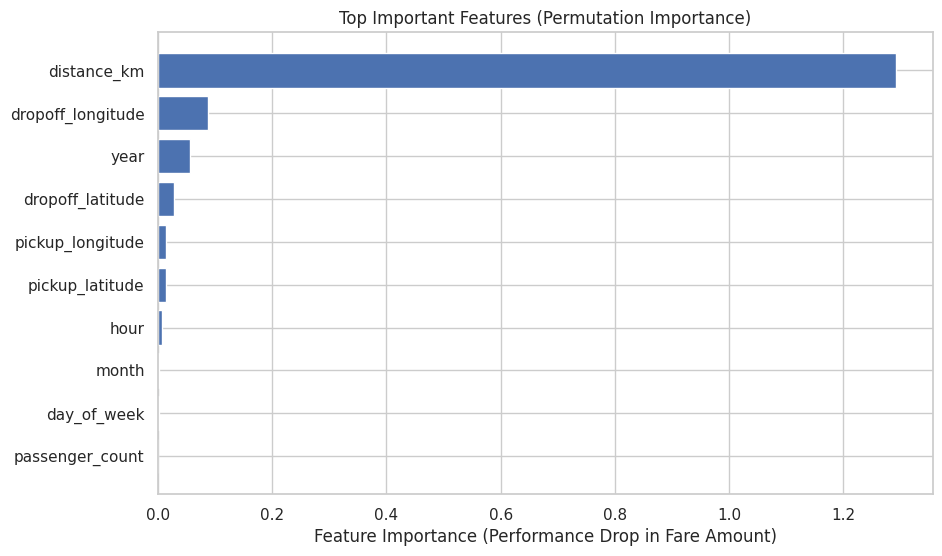

In [ ]:
print("\n" + "="*50 + "\nAPPLYING XAI: NYC TAXI (GLOBAL & LOCAL INSIGHTS)\n" + "="*50)

# We will use the best-performing fast model: Gradient Boosting
model_for_xai = models_taxi['Gradient Boosting']
print(f"Explaining the '{model_for_xai.__class__.__name__}' model.")
print("\n--- 1. Calculating Permutation Feature Importance... ---")
# We'll use a smaller sample of the test set for faster permutation
X_test_sample, y_test_sample = resample(X_test_scaled, y_test, n_samples=50000, random_state=42)

result = permutation_importance(
    model_for_xai,
    X_test_sample,
    y_test_sample,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Feature Importance (Performance Drop in Fare Amount)")
plt.title("Top Important Features (Permutation Importance)")
plt.show()


--- 1. Calculating Permutation Feature Importance... ---


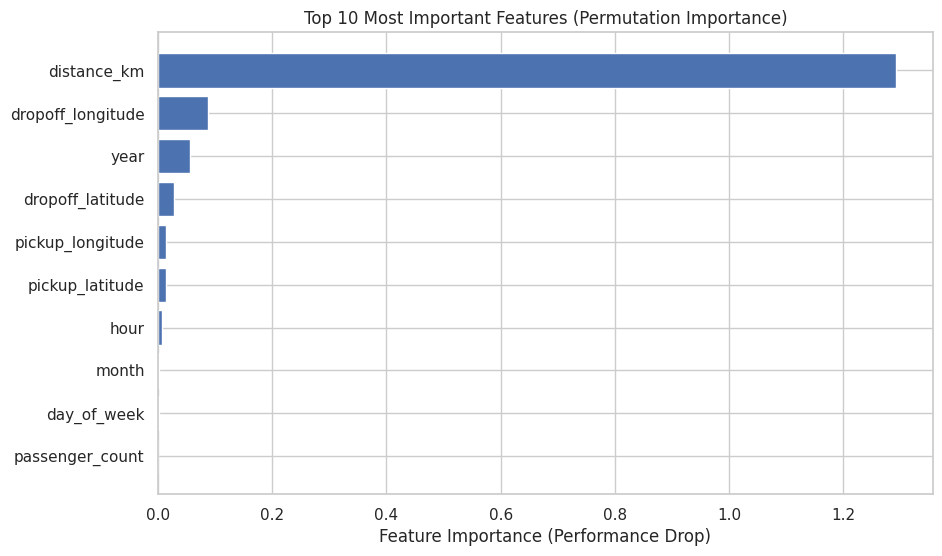

In [ ]:
model_to_explain = models_taxi['Gradient Boosting']

print("\n--- 1. Calculating Permutation Feature Importance... ---")
# We'll use the sampled test set for permutation importance for faster computation
# X_test_sample and y_test_sample were created in the previous XAI cell for NYC Taxi.
result = permutation_importance(
    model_to_explain,
    X_test_sample, # Use the sampled, scaled test data
    y_test_sample, # Use the sampled test labels
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Get the top 10 most important features
sorted_idx = result.importances_mean.argsort()
top_10_idx = sorted_idx[-10:]

# Use the original feature names for better readability
# The 'X' DataFrame contains the original feature names before scaling.
top_10_names = [X.columns[i] for i in top_10_idx]
top_10_importances = result.importances_mean[top_10_idx]

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(top_10_names, top_10_importances)
plt.xlabel("Feature Importance (Performance Drop)")
plt.title("Top 10 Most Important Features (Permutation Importance)")
plt.show()

### PDP


--- 2. Calculating Partial Dependence Plots (PDP)... ---


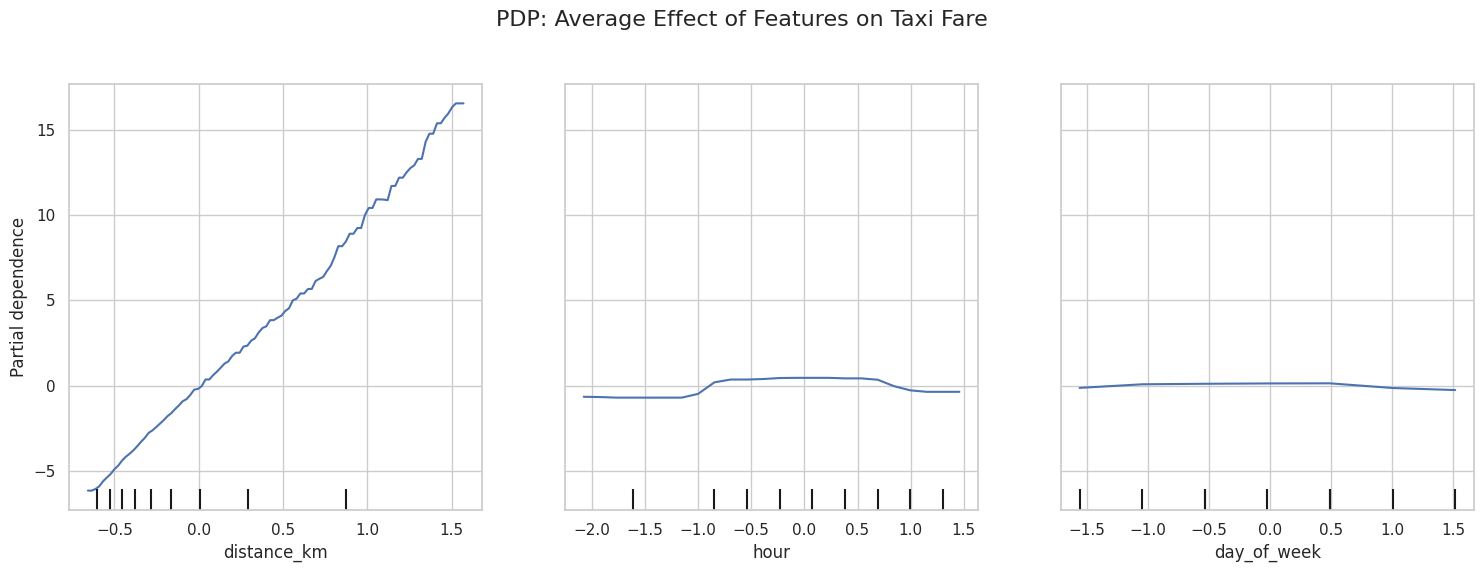

In [ ]:
# --- XAI 2: Partial Dependence Plots (PDP) (Global) ---
print("\n--- 2. Calculating Partial Dependence Plots (PDP)... ---")
features_to_plot = ['distance_km', 'hour', 'day_of_week']
feature_indices = [list(feature_names).index(f) for f in features_to_plot]

fig, ax = plt.subplots(figsize=(15, 6))
fig.suptitle('PDP: Average Effect of Features on Taxi Fare', fontsize=16)
PartialDependenceDisplay.from_estimator(
    model_for_xai,
    X_test_scaled, # Use the full scaled test set
    features=feature_indices,
    feature_names=feature_names,
    kind="average",
    n_cols=3,
    ax=ax,
    n_jobs=-1
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### ICE


--- 3. Calculating Individual Conditional Expectation (ICE)... ---


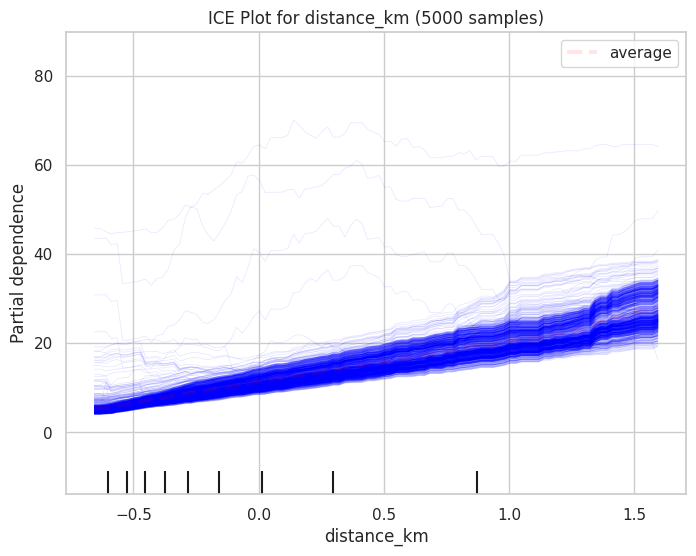

In [ ]:
# --- XAI 3: Individual Conditional Expectation (ICE) (Global) ---
print("\n--- 3. Calculating Individual Conditional Expectation (ICE)... ---")
# We'll use the same 5000-sample test set from permutation
# and plot for 'distance_km'
try:
    dist_index = list(feature_names).index('distance_km')

    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        model_for_xai,
        X_test_sample,
        features=[dist_index],
        feature_names=feature_names,
        kind="both", # "both" = ICE lines + PDP line
        ax=ax,
        n_jobs=-1,
        line_kw={"color": "blue", "alpha": 0.1},
        pd_line_kw={"color": "red", "linestyle": "--", "linewidth": 3}
    )
    ax.set_title('ICE Plot for distance_km (5000 samples)')
    plt.show()
except Exception as e:
    print(f"Error plotting ICE: {e}")

### LIME


--- 4. Calculating LIME Explanation (Local)... ---

Explaining Trip #0...
  - Model's Predicted Fare: $8.27
  - Actual Fare: $8.50
LIME explanation saved to 'lime_explanation_taxi.html'.


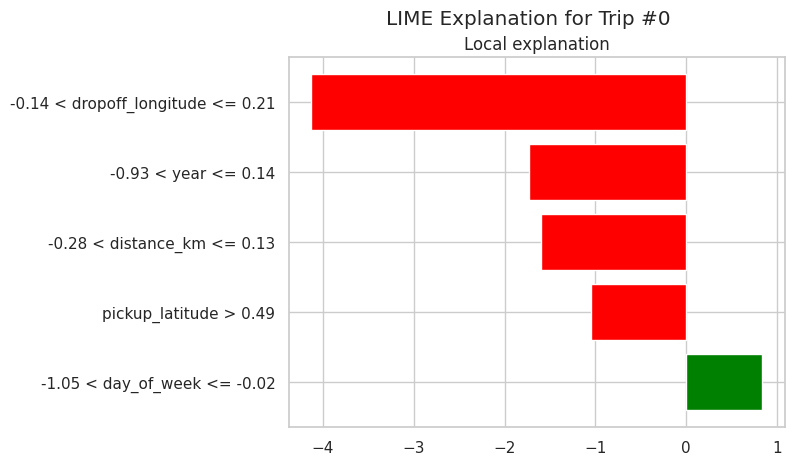

In [ ]:
# --- XAI 4: LIME (Local) ---
print("\n--- 4. Calculating LIME Explanation (Local)... ---")

# 1. Create the LIME Explainer for regression
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=list(feature_names),
    mode='regression',
    random_state=42
)

# 2. Pick a trip to explain (e.g., the first one in the test set)
trip_idx = 0
trip_data = X_test_scaled[trip_idx]
true_fare = y_test.iloc[trip_idx]
pred_fare = model_for_xai.predict([trip_data])[0]

print(f"\nExplaining Trip #{trip_idx}...")
print(f"  - Model's Predicted Fare: ${pred_fare:.2f}")
print(f"  - Actual Fare: ${true_fare:.2f}")

# 3. Generate explanation
exp = explainer.explain_instance(
    data_row=trip_data,
    predict_fn=model_for_xai.predict,
    num_features=5 # Top 5 factors
)

# 4. Show explanation
exp.save_to_file('lime_explanation_taxi.html')
print("LIME explanation saved to 'lime_explanation_taxi.html'.")
fig = exp.as_pyplot_figure()
plt.suptitle('LIME Explanation for Trip #0')
plt.show()

# Dataset 3: Chest X-Ray Images (Pneumonia)

* (Image, Classification)
* Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
# # --- Dataset 3: Chest X-Ray Images (Pneumonia) ---
print("\n--- Downloading Dataset 3: Chest X-Ray Images ---")
!mkdir -p dataset_3
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p dataset_3
!unzip -q dataset_3/chest-xray-pneumonia.zip -d dataset_3
!rm dataset_3/chest-xray-pneumonia.zip
print("Dataset 3 ready in folder: dataset_3/")


--- Downloading Dataset 3: Chest X-Ray Images ---
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:40<00:00, 190MB/s]
100% 2.29G/2.29G [00:40<00:00, 60.7MB/s]
Dataset 3 ready in folder: dataset_3/


## Analysing



In [ ]:
train_path = '/content/dataset_3/chest_xray/train/'
test_path = '/content/dataset_3/chest_xray/test/'

In [ ]:
# Helper: get classes (folders)
train_normal = glob(train_path+"NORMAL/*.jpeg")
train_pneu = glob(train_path+"PNEUMONIA/*.jpeg")

print("Normal X-rays:", len(train_normal))
print("Pneumonia X-rays:", len(train_pneu))

Normal X-rays: 1341
Pneumonia X-rays: 3875


## Pre-processing

In [ ]:
img_size = 64  # 64x64 pixel resize (simpler for ML)
X = []
y = []

for img_path in tqdm(train_normal):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    X.append(img.flatten())
    y.append(0)  # normal

for img_path in tqdm(train_pneu):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    X.append(img.flatten())
    y.append(1)  # pneumonia

X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

100%|██████████| 3875/3875 [00:15<00:00, 252.23it/s]


X shape: (5216, 4096)
y shape: (5216,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (4172, 4096) Val: (1044, 4096)


## Build the models and evaluation

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=4),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'MLP (Neural Network)':MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', max_iter=30, random_state=42),
}

In [ ]:
models_taxi = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5),
    # 'MLP (Neural Network)': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42, early_stopping=True),
    # 'SVM (Support Vector Machine)': SVR(kernel='rbf', C=1.0) # SVR is very slow!
}

In [ ]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    pre = model.predict(X_val)
    accuracy_score = model.score(X_val, y_val)
    print(f"{name} accuracy: {accuracy_score:.4f}")
    print("=====================================")
    print()
    print(classification_report(y_val, pre))
print("\nAll models trained successfully.")

Training Random Forest...
Random Forest accuracy: 0.9646

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       268
           1       0.97      0.98      0.98       776

    accuracy                           0.96      1044
   macro avg       0.96      0.95      0.95      1044
weighted avg       0.96      0.96      0.96      1044

Training Gradient Boosting...
Gradient Boosting accuracy: 0.9588

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       268
           1       0.96      0.99      0.97       776

    accuracy                           0.96      1044
   macro avg       0.96      0.93      0.94      1044
weighted avg       0.96      0.96      0.96      1044

Training MLP (Neural Network)...
MLP (Neural Network) accuracy: 0.9195

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       268
           1       0.99      0.90      0.

## Apply XAI

### LIME

In [ ]:
from sklearn.metrics import accuracy_score
mlp_cv = MLPClassifier(hidden_layer_sizes=(128,), alpha=0.01, early_stopping=True, random_state=42, max_iter=30)
mlp_cv.fit(X_train, y_train)
print("MLP w/ regularization Accuracy:", accuracy_score(y_val, mlp_cv.predict(X_val)))

MLP w/ regularization Accuracy: 0.946360153256705


In [ ]:
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=[f"pix{i}" for i in range(X_train.shape[1])],
                                              class_names=['Normal', 'Pneumonia'], discretize_continuous=True)
exp = explainer.explain_instance(X_val[0], models['Random Forest'].predict_proba, num_features=10)

In [ ]:
from IPython.display import HTML, display
styled_html = f'<div style="background:white;">{exp.as_html()}</div>'
display(HTML(styled_html))